In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi
import scoobi.utils as utils

import lina

print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()

client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


/home/kianmilani/Projects/scoob-interface/scoobi/scoobi.py
/home/kianmilani/Projects/lina/lina/__init__.py


In [2]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp02')
I.npsf = 256

In [3]:
reload(scoobi)
xc, yc = (4600, 3400)
xc, yc = (4500, 3350)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)


In [6]:
I.set_zwo_exp_time(0.00012, client0)

Set the ZWO exposure time to 1.20e-04s


In [5]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [7]:
I.set_fib_atten(30, client)

Set the fiber attenuation to 30.0


In [12]:
scoobi.move_psf(50, 0, client0)

In [15]:
scoobi.move_psf(0, -50, client0)

# Run FDPR2

In [8]:
from magpyx.utils import ImageStream
fdpr2_amp_stream = ImageStream('fdpr2_amp')
fdpr2_phs_stream = ImageStream('fdpr2_phase')

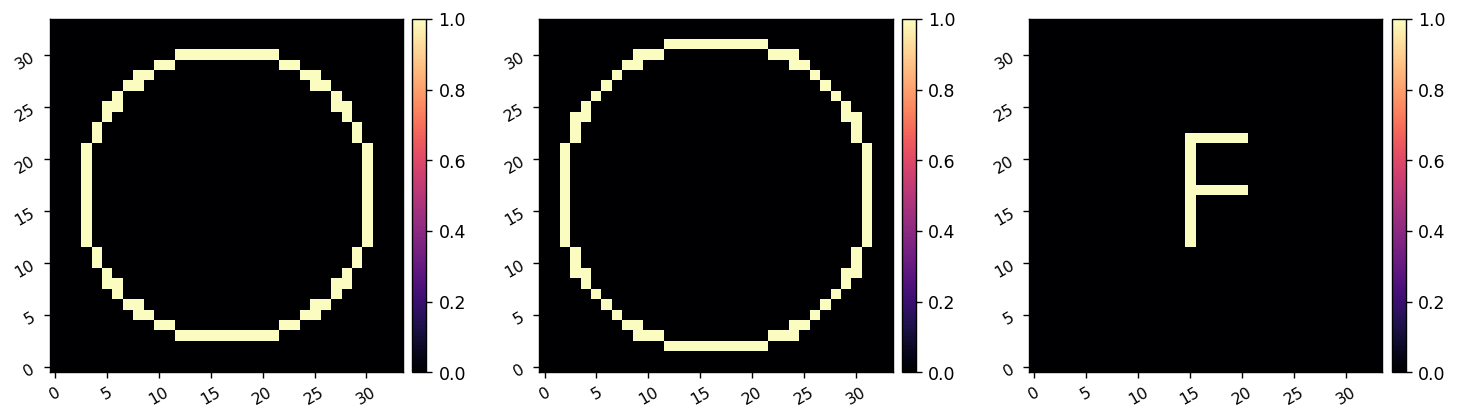

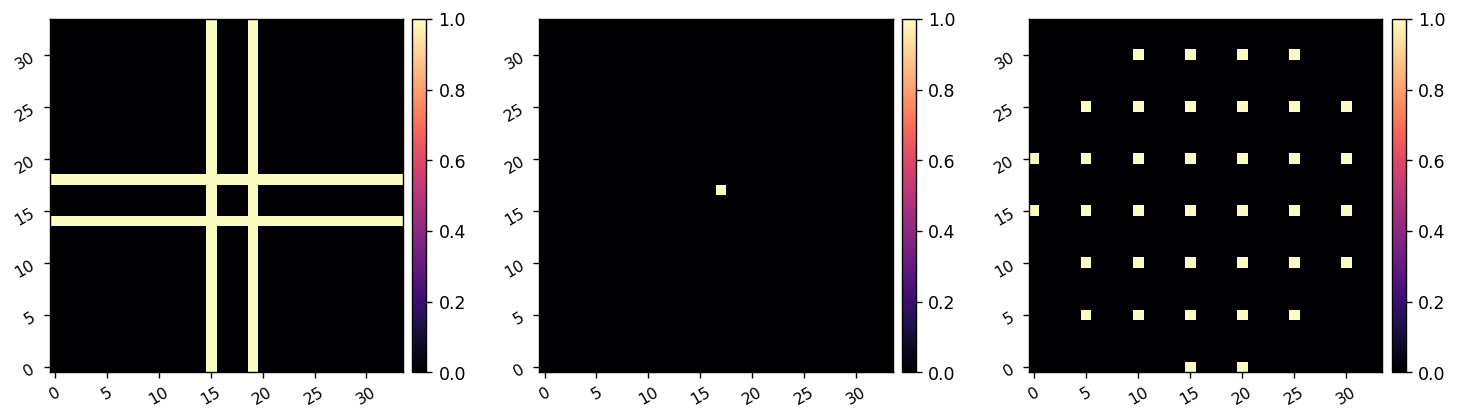

In [9]:
reload(lina.utils)

ring_13 = lina.utils.make_ring(rad=13, Nact=34)
ring_14 = lina.utils.make_ring(rad=14, Nact=34)
ring_15 = lina.utils.make_ring(rad=15, Nact=34)
ring_16 = lina.utils.make_ring(rad=16, Nact=34)
f = lina.utils.make_f()
imshow3(ring_14, ring_15, f)

cross = lina.utils.make_cross_command(xc=[-1, 3], yc=[2,-2])

poke = np.zeros((34,34))
poke[17,17] = 1
# poke[25,17] = 1
# poke[18,31] = 1

pokes = np.zeros((34,34))
for i in range(34):
    for j in range(34):
        if i%5==0 and j%5==0:
            pokes[i,j] = 1
pokes *= I.dm_mask
imshow3(cross, poke, pokes)

In [31]:
amp = 50e-9
# command = np.zeros((34,34))
# command = amp*ring_13
# command = amp*ring_14
# command = amp*ring_15
# command = amp*ring_16
# command = amp*f
# command = amp*cross
command = amp*pokes

I.set_dm(command)

INFO:utils:Got semaphore index 0.
INFO:fdpr2:Estimated phase RMS: 0.215 (rad)
INFO:fdpr2:Estimated amplitude RMS: 7.78 (%)
INFO:fdpr2:Estimated Strehl: 0.95 (0.95 phase-only and 0.99 amplitude-only)
INFO:fdpr2:Updated shmims fdpr2_phase and fdpr2_amp


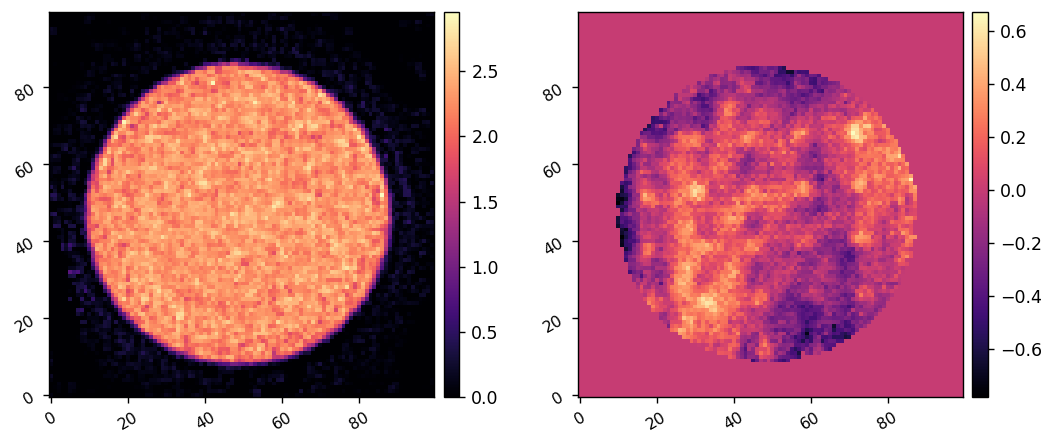

In [32]:
from magpyx.fdpr2 import console, tools

config_params = tools.Configuration('fdpr2_kilo_dmdiv_km')

fitdict, Imeas_cen = console.estimate_oneshot(config_params)
I.zero_dm()

fitdict.update({
    'AMP':fdpr2_amp_stream.grab_latest(),
    'PHS':fdpr2_phs_stream.grab_latest(),
    'dm_command':command,
    'Imeas':Imeas_cen, 
})

imshow2(fitdict['AMP'], fitdict['PHS'], npix=100)

In [33]:
# utils.save_pickle(f'data/{today}_fdpr2_postfpm_ref.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_postfpm_ring_13.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_postfpm_ring_14.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_postfpm_ring_15.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_postfpm_ring_16.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_postfpm_f.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_postfpm_cross.pkl', fitdict)
utils.save_pickle(f'data/{today}_fdpr2_postfpm_pokes.pkl', fitdict)


Saved data to:  data/20250117_fdpr2_postfpm_pokes.pkl


In [33]:
I.zero_dm()

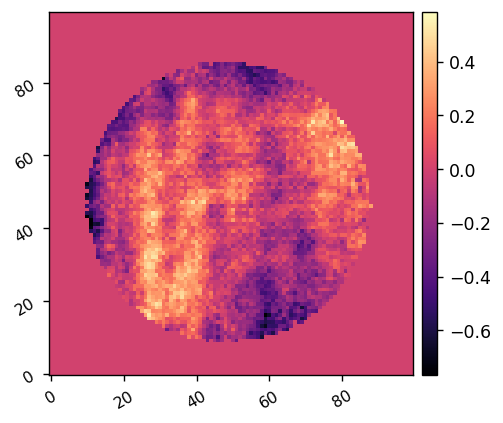

In [35]:
date = 20250117

ref_data = utils.load_pickle(f'data/{date}_fdpr2_postfpm_ref.pkl')
ref_phs = ref_data['PHS']
imshow1(ref_phs, npix=100)

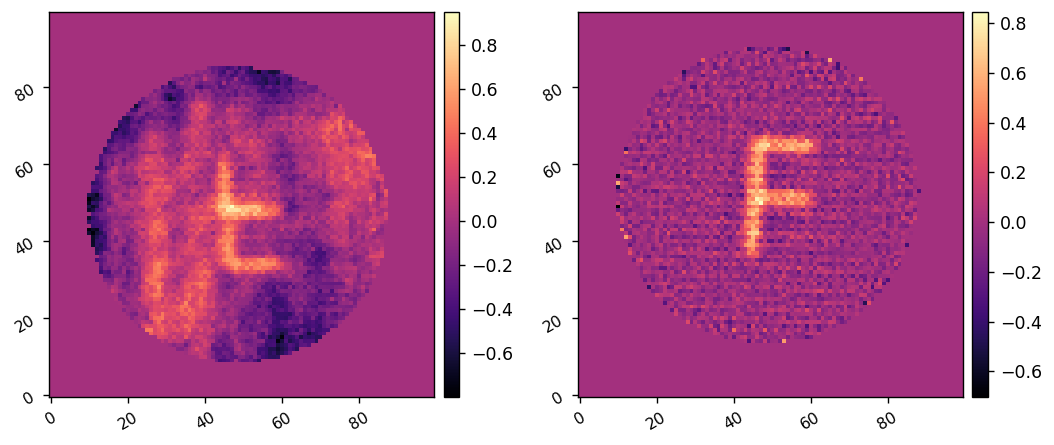

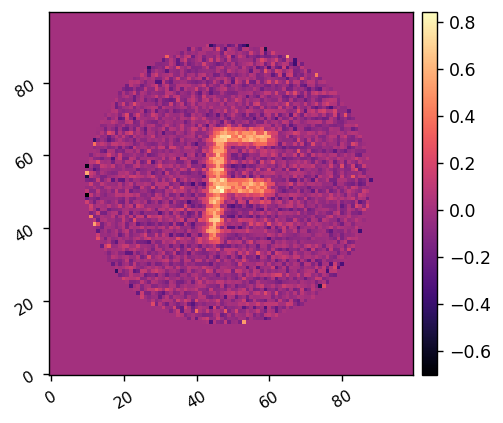

In [43]:
f_data = utils.load_pickle(f'data/{date}_fdpr2_postfpm_f.pkl')
f_phs = f_data['PHS']
diff = f_phs-ref_phs
imshow2(f_phs, xp.flipud(diff), npix=100)
imshow1(xp.flipud(diff), npix=100)

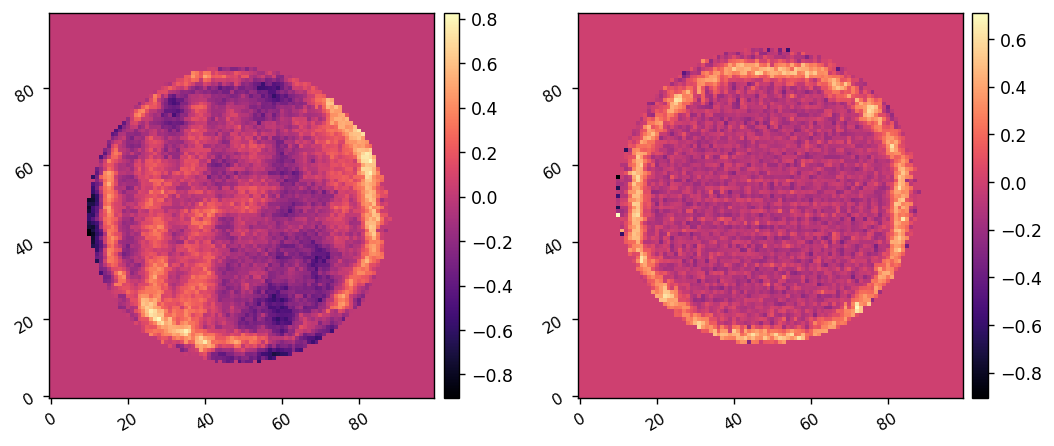

In [42]:
ring13_data = utils.load_pickle(f'data/{date}_fdpr2_postfpm_ring_13.pkl')
ring13_phs = ring13_data['PHS']
diff = ring13_phs-ref_phs
imshow2(ring13_phs, xp.flipud(diff), npix=100)

In [10]:
14/34 * 2 * 10.2

8.399999999999999

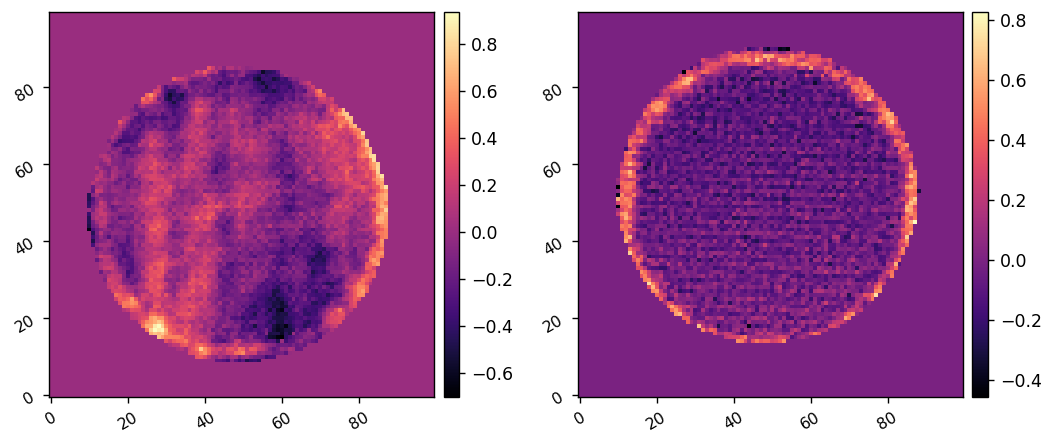

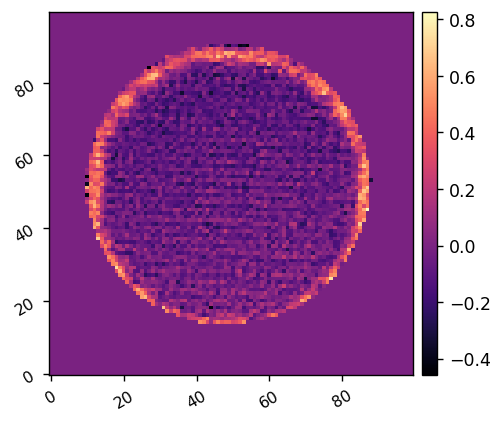

In [44]:
ring14_data = utils.load_pickle(f'data/{date}_fdpr2_postfpm_ring_14.pkl')
ring14_phs = ring14_data['PHS']
diff = ring14_phs-ref_phs
imshow2(ring14_phs, xp.flipud(diff), npix=100)
imshow1(xp.flipud(diff), npix=100)


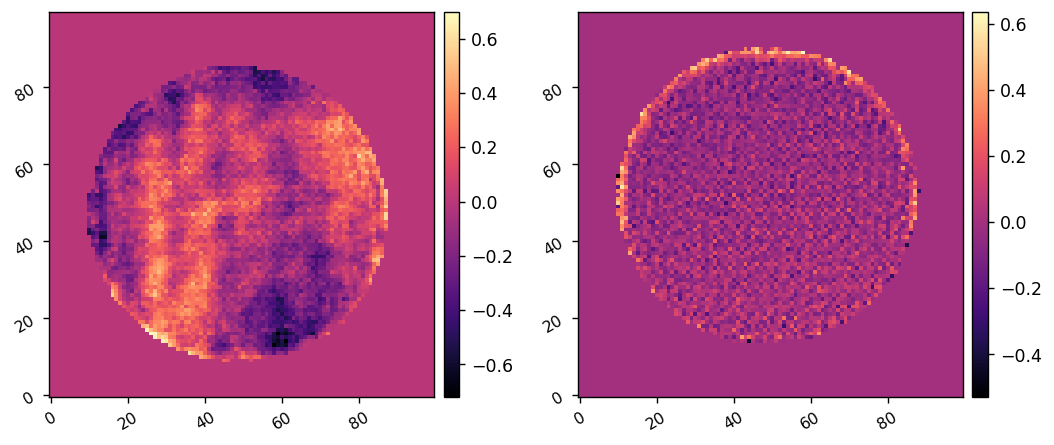

In [39]:
ring15_data = utils.load_pickle(f'data/{date}_fdpr2_postfpm_ring_15.pkl')
ring15_phs = ring15_data['PHS']
diff = ring15_phs-ref_phs
imshow2(ring15_phs, xp.flipud(diff), npix=100)

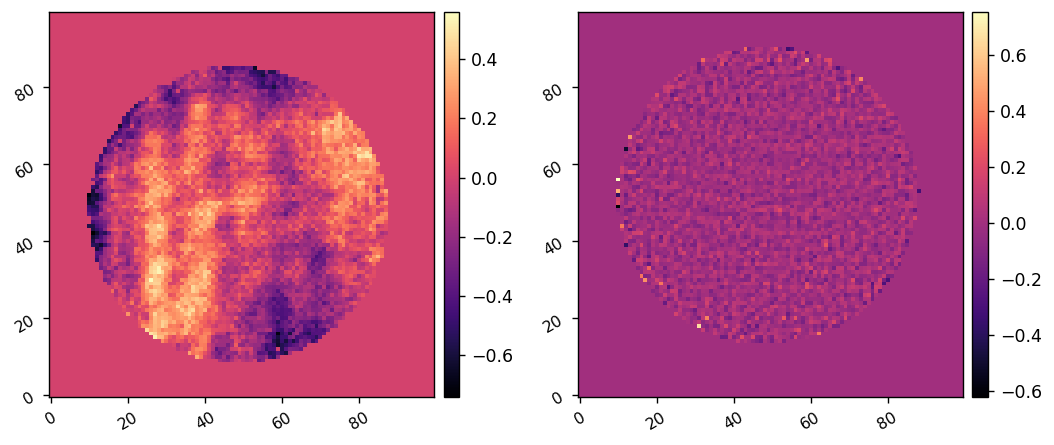

In [40]:
ring16_data = utils.load_pickle(f'data/{date}_fdpr2_postfpm_ring_16.pkl')
ring16_phs = ring16_data['PHS']
diff = ring16_phs-ref_phs
imshow2(ring16_phs, xp.flipud(diff), npix=100)